In [1]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
import tfrecord
import cv2
import glob
import torchvision
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
torchvision.models

<module 'torchvision.models' from 'C:\\Users\\alex\\anaconda3\\lib\\site-packages\\torchvision\\models\\__init__.py'>

In [4]:
for prop, value in vars(torchvision.models).items():
    print(prop, ":", value)

__name__ : torchvision.models
__doc__ : None
__package__ : torchvision.models
__loader__ : <_frozen_importlib_external.SourceFileLoader object at 0x00000281D45B4670>
__spec__ : ModuleSpec(name='torchvision.models', loader=<_frozen_importlib_external.SourceFileLoader object at 0x00000281D45B4670>, origin='C:\\Users\\alex\\anaconda3\\lib\\site-packages\\torchvision\\models\\__init__.py', submodule_search_locations=['C:\\Users\\alex\\anaconda3\\lib\\site-packages\\torchvision\\models'])
__path__ : ['C:\\Users\\alex\\anaconda3\\lib\\site-packages\\torchvision\\models']
__file__ : C:\Users\alex\anaconda3\lib\site-packages\torchvision\models\__init__.py
__cached__ : C:\Users\alex\anaconda3\lib\site-packages\torchvision\models\__pycache__\__init__.cpython-39.pyc
__builtins__ : 

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 2575: character maps to <undefined>

In [3]:
import glob
url_base = 'tpu-getting-started/tfrecords-jpeg-'
resolutions = ['192', '224', '331', '512']
resolution = resolutions[1]
folders = ['train', 'val', 'test']
description = {
    "id": "byte",
    "image": "byte"
}

def transform_from_tsrecord_to_df(description, url_base, resolution, folder, is_class):
    df = pd.DataFrame({'id': pd.Series(dtype='str'), 'class': pd.Series(dtype='int'), 'image': pd.Series(dtype='object')})
    url = '{0}{1}x{1}/{2}/*'.format(url_base, resolution, folder)
    if is_class:
        description["class"] = "int"
    tf_files = glob.glob('{0}{1}x{1}/{2}/*'.format(url_base, resolution, folder))
    for tf_file in tf_files:
        loader = tfrecord.tfrecord_loader(tf_file, None, description)
        for record in loader:
                id_str = ''.join(map(chr, record['id']))
                class_value = None if is_class else record['class'][0].item()
                img_np = cv2.imdecode(record["image"], cv2.IMREAD_COLOR)
                img_np_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
                df.loc[len(df.index)] = [id_str, class_value, img_np_rgb]
    return df

df_train = transform_from_tsrecord_to_df(description, url_base, resolution, folders[0], True)
df_validation = transform_from_tsrecord_to_df(description, url_base, resolution, folders[1], True)
df_test = transform_from_tsrecord_to_df(description, url_base, resolution, folders[2], False)

KeyError: "Key class doesn't exist (select from ['id', 'image'])!"

In [378]:
print(df_train.dtypes)
# dataset[['id', 'class']]
# plt.imshow(df_train.loc[0]['image'])
df_train.iloc[10, 0]

id       object
class     int64
image    object
dtype: object


'38cb16e2b'

In [395]:
print(df_train.shape[0])
print(sorted(df_train['class'].unique()))
print(len(df_train['class'].unique()))
UNIQUE_LABEL_COUNT = len(df_train['class'].unique())

12753
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]
104


In [396]:
print(df_validation.shape[0])
print(sorted(df_validation['class'].unique()))
print(len(df_validation['class'].unique()))
UNIQUE_LABEL_COUNT = len(df_validation['class'].unique())

3712
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]
104


In [412]:



class FlowersDataset(Dataset):
    def __init__(self, df, UNIQUE_LABEL_COUNT, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]
        image = self.df.iloc[idx, 2]
        
        if self.transform:
            image = self.transform(image)
            
        y = np.zeros(UNIQUE_LABEL_COUNT, dtype=np.float32)
        y[label] = int(1)
        return img_id, y, image.T
    
train_dataset = FlowersDataset(df_train, UNIQUE_LABEL_COUNT)
print(train_dataset)

In [413]:
i = 0
for img_id, label, image in train_dataset:
    i += 1
    if (i < 5):
        print(img_id, label)
        print(image.shape)

338ab7bac [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
(3, 224, 224)
90ffc5d69 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
(3, 224, 224)
76feda65b [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

In [414]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1,
)

i = 0
for img_ids, labels, images in train_loader:
    if i < 1:
        i = i + 1
        print(img_ids, labels)
        print(images[0].shape)
        print(images[0].byte())
        print ('--------------')

('338ab7bac',) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([3, 224, 224])
tensor([[[17, 18, 19,  ..., 24, 26, 25],
         [15, 16, 16,  ..., 23, 25, 25],
         [16, 16, 17,  ..., 22, 24, 25],
         ...,
         [22, 22, 22,  ..., 35, 31, 32],
         [26, 24, 23,  ..., 32, 31, 30],
         [28, 26, 23,  ..., 25, 31, 29]],

        [[20, 22, 23,  ..., 32, 34, 33],
         [19, 20, 20,  ..., 31, 33, 33],
         [18, 18, 19,  ..., 31, 32, 33],
         ...,
         [24, 24, 24,  ..., 46, 42, 43],
         [28, 26, 25,  ..., 38, 40, 40],
      

In [415]:
i = 0
for img_ids, labels, images in train_loader:
    if i == 0:
        i += 1
        print(img_ids, labels)
        print(images[0].T.shape)
        print(images[0].T)
        print ('--------------')

('338ab7bac',) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([224, 224, 3])
tensor([[[17, 20,  9],
         [15, 19,  5],
         [16, 18,  4],
         ...,
         [22, 24, 10],
         [26, 28, 14],
         [28, 30, 16]],

        [[18, 22,  8],
         [16, 20,  6],
         [16, 18,  4],
         ...,
         [22, 24, 10],
         [24, 26, 12],
         [26, 28, 14]],

        [[19, 23,  8],
         [16, 20,  5],
         [17, 19,  5],
         ...,
         [22, 24, 10],
         [23, 25, 11],
         [23, 25, 11]],

        ...,

        [[2

In [416]:
model = torchvision.models.resnet50()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [417]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=unique_label_count
    ),
    torch.nn.Sigmoid()
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [418]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCELoss()

In [ ]:
EPOCHS = 1
i = 0
for i in range(EPOCHS):
    epoch_loss = 0
    correct = 0
    incorrect = 0
    for img_ids, labels, images in train_loader:
        i += 1
        
        if (i % 50 == 0):
            print('item: {3}, epoch loss: {0}, incorrect: {1} correct: {2}'.format(loss, incorrect, correct, i))
        
        if (i > 0 ):
            optimizer.zero_grad()
#             print(img_ids, labels)
#             print(labels.shape)
#             print(images.shape)

            z = model(images.float())
#             print('z.shape', z.shape)
#             print('labels.shape', labels.shape)
            
            loss = criterion(z, labels)
#             print ('loss', loss)
            # multiply loss by batch size
            epoch_loss += loss.data.item() * labels.shape[0]

            loss.backward()
            optimizer.step()

    #         print(z)
            _, yhat2 = torch.max(z, 1)
            _, label = torch.max(labels, 1)
#             print('yhat2', yhat2.data.item(), label.data.item())
            if yhat2.data.item() == label.data.item():
                correct += 1
            else:
                incorrect += 1
                
    print('epoch loss: {0}, incorrect: {1} correct: {2}'.format(loss, incorrect, correct))

item: 50, epoch loss: 0.040488582104444504, incorrect: 48 correct: 1
item: 100, epoch loss: 0.041693709790706635, incorrect: 97 correct: 2
item: 150, epoch loss: 0.060545001178979874, incorrect: 145 correct: 4
item: 200, epoch loss: 0.060885634273290634, incorrect: 193 correct: 6
item: 250, epoch loss: 0.04176563024520874, incorrect: 239 correct: 10
item: 300, epoch loss: 0.04143283888697624, incorrect: 284 correct: 15
item: 350, epoch loss: 0.05748273804783821, incorrect: 331 correct: 18
item: 400, epoch loss: 0.048909325152635574, incorrect: 377 correct: 22
item: 450, epoch loss: 0.051741715520620346, incorrect: 425 correct: 24
item: 500, epoch loss: 0.06721755117177963, incorrect: 474 correct: 25
item: 550, epoch loss: 0.053255245089530945, incorrect: 522 correct: 27
item: 600, epoch loss: 0.0432753749191761, incorrect: 570 correct: 29
item: 650, epoch loss: 0.04285290464758873, incorrect: 617 correct: 32
item: 700, epoch loss: 0.06202114373445511, incorrect: 664 correct: 35
item: 7

In [ ]:
# epoch 1 loss: 0.05236416310071945, incorrect: 12099 correct: 654

In [12]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

In [13]:
url = 'tpu-getting-started/tfrecords-jpeg-512x512/train/00-512x512-798.tfrec'
read_labeled_tfrecord(url)

InvalidArgumentError: Could not parse example input, value: 'tpu-getting-started/tfrecords-jpeg-512x512/train/00-512x512-798.tfrec' [Op:ParseExampleV2]

In [23]:
# Load numpy array
url = '1.png'
image_raw = load_sample_image(url)
print("Type {} with dtype {}".format(type(image_raw), image_raw.dtype))
plt.imshow(image_raw)
plt.title("Numpy")
plt.show()

AttributeError: Cannot find sample image: 1.png

In [4]:
import tfrecord
import cv2

url1 = 'tpu-getting-started/tfrecords-jpeg-224x224/train/00-224x224-798.tfrec'
url2 = 'tpu-getting-started/tfrecords-jpeg-224x224/train/01-224x224-798.tfrec'
url3 = 'tpu-getting-started/tfrecords-jpeg-224x224/train/'

loader = tfrecord.tfrecord_loader(url3, None, {
    "id": "byte",
    "class": "int",
    "image": "byte"
})
items = []
for record in loader:
#     print(record["class"])

    img_np = cv2.imdecode(record["image"], cv2.IMREAD_COLOR)
    img_np_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    imgs.append(img_np_rgb)
#     plt.imshow(img_np)
print(len(imgs))
plt.imshow(imgs[len(imgs)-1])    

PermissionError: [Errno 13] Permission denied: 'tpu-getting-started/tfrecords-jpeg-224x224/train/'

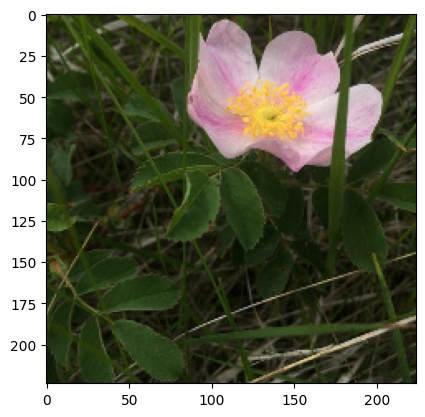

In [16]:
import tfrecord
import cv2

def decode_image(features):
    # get BGR image from bytes
#     features["image"] = cv2.imdecode(features["image"], -1)
    features["image"] = cv2.imdecode(features["image"], cv2.IMREAD_COLOR)
    features["image"] = cv2.cvtColor(features["image"], cv2.COLOR_BGR2RGB)
#     plt.imshow(features["image"])    
    return features


description = {
    "id": "byte",
    "class": "int",
    "image": "byte"
}

url1 = "tpu-getting-started/tfrecords-jpeg-224x224/train/00-224x224-798.tfrec"
url2 = "tpu-getting-started/tfrecords-jpeg-224x224/train/01-224x224-798.tfrec"

dataset = tfrecord.torch.TFRecordDataset(url1,
                                         index_path=None,
                                         description=description,
                                         transform=decode_image)

for data in dataset:
#     data = next(iter(dataset))
    plt.imshow(data["image"])    

In [17]:
dataset

In [ ]:
# def decode_image(image_data):
#     image = tf.image.decode_jpeg(image_data, channels=3)
#     image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
#     image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
#     return image

# def read_labeled_tfrecord(example):
#     LABELED_TFREC_FORMAT = {
#         "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
#         "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
#     }
#     example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
#     image = decode_image(example['image'])
#     label = tf.cast(example['class'], tf.int32)
#     return image, label # returns a dataset of (image, label) pairs

# def load_dataset(filenames, labeled=True, ordered=False):
#     # Read from TFRecords. For optimal performance, reading from multiple files at once and
#     # disregarding data order. Order does not matter since we will be shuffling the data anyway.

#     ignore_order = tf.data.Options()
#     if not ordered:
#         ignore_order.experimental_deterministic = False # disable order, increase speed

#     dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
#     dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
#     dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
#     # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
#     return dataset

In [66]:
# import torch
# from tfrecord.torch.dataset import TFRecordDataset

# tfrecord_path = 'tpu-getting-started/tfrecords-jpeg-512x512/train/00-512x512-798.tfrec'
# index_path = None
# description = { "id": "byte", "class": "int", "image": "byte" }
# dataset = TFRecordDataset(tfrecord_path, index_path, description)
# loader = torch.utils.data.DataLoader(dataset, batch_size=32)

# data = next(iter(loader))
# print(data)

In [11]:
df_test = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2022/test.csv')
df_test['date'] = df_test['date'].apply(lambda item: datetime.strptime(item, '%Y-%m-%d'))
df_test.head(100)

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques
...,...,...,...,...,...
95,70223,2021-01-02,Spain,KaggleRama,Kaggle for Kids: One Smart Goose
96,70224,2021-01-03,Belgium,KaggleMart,Kaggle Advanced Techniques
97,70225,2021-01-03,Belgium,KaggleMart,Kaggle Getting Started
98,70226,2021-01-03,Belgium,KaggleMart,Kaggle Recipe Book


# Holidays
The first and I hope unique feature, I'll parse all the public holidays for all the countries

In [13]:
countries = df['country'].unique()
years = df.append(df_test, ignore_index=True)['date'].dt.year.unique()
print(countries, years);

['Belgium' 'France' 'Germany' 'Italy' 'Poland' 'Spain'] [2017 2018 2019 2020 2021]


In [15]:

# https://www.officeholidays.com/countries/various/belgium/2019
# df_holidays = df.copy()
# df_holidays['date'] = df_holidays['date'].apply(lambda item: datetime.strptime(item, '%Y-%m-%d'))
# print(df_holidays.head())
dfs = []
for country in countries:
    for year in years:
        url = 'https://www.officeholidays.com/countries/%s/%s' % (country.lower(), str(year))
        print(url)
        officeholidays_table = pd.read_html(url)
        df_officeholidays = officeholidays_table[0]
        df_officeholidays.insert(0, "country", country)
        df_officeholidays.insert(0, "date",  df_officeholidays['Date'].apply(lambda item: datetime.strptime(item + ' ' + str(year), '%b %d %Y')))
        if 'Type' in df_officeholidays.columns:
            t = df_officeholidays['Type']
        elif df_officeholidays['Comments'].str.contains('Holiday').all():
#             print(df_officeholidays['Comments'].str.contains('Holiday').all())
            t = df_officeholidays['Comments']
        else:
            t = 'Public Holiday'
        df_officeholidays['type'] = t
        df_officeholidays = df_officeholidays[['date', 'country', 'type']]
#         print(df_officeholidays[['date', 'country', 'type']].head())
#         df_holidays.merge(df_officeholidays, how='left', on=['date', 'country'])
#         df_holidays = pd.merge(df_holidays, df_officeholidays,  how='left', left_on=['date', 'country'], right_on=['date', 'country'])
#         print(df_officeholidays.head())
        dfs.append(df_officeholidays.loc[df_officeholidays['type'] == 'Public Holiday' ])
    

df_officeholidays.head()

https://www.officeholidays.com/countries/belgium/2017
https://www.officeholidays.com/countries/belgium/2018
https://www.officeholidays.com/countries/belgium/2019
https://www.officeholidays.com/countries/belgium/2020
https://www.officeholidays.com/countries/belgium/2021
https://www.officeholidays.com/countries/france/2017
https://www.officeholidays.com/countries/france/2018
https://www.officeholidays.com/countries/france/2019
https://www.officeholidays.com/countries/france/2020
https://www.officeholidays.com/countries/france/2021
https://www.officeholidays.com/countries/germany/2017
https://www.officeholidays.com/countries/germany/2018
https://www.officeholidays.com/countries/germany/2019
https://www.officeholidays.com/countries/germany/2020
https://www.officeholidays.com/countries/germany/2021
https://www.officeholidays.com/countries/italy/2017
https://www.officeholidays.com/countries/italy/2018
https://www.officeholidays.com/countries/italy/2019
https://www.officeholidays.com/countrie

,date,country,type
0,2021-01-01,Spain,Public Holiday
1,2021-01-06,Spain,Public Holiday
2,2021-03-01,Spain,Regional Holiday
3,2021-03-01,Spain,Regional Holiday
4,2021-03-13,Spain,Regional Holiday


In [16]:
df_officeholidays2 = pd.concat(dfs, ignore_index=True)
# df_officeholidays2.where(df_officeholidays2['type'] != 'Regional Holiday')
print(df_officeholidays2.groupby('type').count())

                date  country
type                         
Public Holiday   348      348


In [17]:
df_new = pd.merge(df, df_officeholidays2, left_on = ['date', 'country'], right_on = ['date', 'country'], how='left')
df_new['type'] = df_new['type'].fillna('Not a Holiday')

In [18]:
df_new

,row_id,date,country,store,product,num_sold,type
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663,Public Holiday
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615,Public Holiday
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480,Public Holiday
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710,Public Holiday
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240,Public Holiday
...,...,...,...,...,...,...,...
70123,70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614,Not a Holiday
70124,70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215,Not a Holiday
70125,70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158,Not a Holiday
70126,70126,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book,135,Not a Holiday


In [47]:
df_new['day_of_week'] = df_new["date"].dt.dayofweek
df_new['weekend'] = np.where(df_new['day_of_week'].isin([5,6]), 1,0)
df_new['day_of_month'] = df_new["date"].dt.day
df_new["day_of_year"] = df_new["date"].apply(lambda x: x.day_of_year if calendar.isleap(x.year) == False or x.day_of_year < 60 else x.day_of_year - 1)

df_new["month"] = df_new["date"].dt.month
df_new['quartar'] = df_new["date"].dt.quarter
df_new['year'] = df_new["date"].dt.year

In [48]:
df_new[['num_sold']].mean()

num_sold    194.296986
dtype: float64

In [49]:
df_new[['num_sold', 'day_of_week', 'type']].groupby(['day_of_week', 'type']).mean()

num_sold
day_of_week type                      
0           Not a Holiday   183.374058
            Public Holiday  197.839583
1           Not a Holiday   183.415263
            Public Holiday  198.233108
2           Not a Holiday   183.285597
            Public Holiday  185.137821
3           Not a Holiday   183.890471
            Public Holiday  172.121324
4           Not a Holiday   192.989247
            Public Holiday  181.419872
5           Not a Holiday   211.568934
            Public Holiday  209.692708
6           Not a Holiday   221.411010
            Public Holiday  214.557065

In [52]:
df_new[['num_sold', 'month']].groupby('month').mean()

,num_sold
month,
1,209.161290
2,200.267883
3,192.721606
4,186.900868
5,192.008905
6,188.946181
7,186.433468
8,187.437164
9,184.875347


In [36]:
df_new[['num_sold', 'day_of_year']].groupby('day_of_year').mean()

,num_sold
day_of_year,
1,268.052083
2,241.630208
3,227.442708
4,226.468750
5,239.135417
...,...
361,273.041667
362,314.588542
363,369.812500


In [56]:
x_train = df_new[['country', 'store', 'product', 'type', 'day_of_week', 'weekend', 'day_of_month', 'day_of_year', 'month', 'quartar', 'year']]
y_train = df_new[['num_sold']]
x_train.head(100)

,country,store,product,type,day_of_week,weekend,day_of_month,day_of_year,month,quartar,year
0,Belgium,KaggleMart,Kaggle Advanced Techniques,Public Holiday,6,1,1,1,1,1,2017
1,Belgium,KaggleMart,Kaggle Getting Started,Public Holiday,6,1,1,1,1,1,2017
2,Belgium,KaggleMart,Kaggle Recipe Book,Public Holiday,6,1,1,1,1,1,2017
3,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,Public Holiday,6,1,1,1,1,1,2017
4,Belgium,KaggleRama,Kaggle Advanced Techniques,Public Holiday,6,1,1,1,1,1,2017
...,...,...,...,...,...,...,...,...,...,...,...
95,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,Not a Holiday,0,0,2,2,1,1,2017
96,Belgium,KaggleMart,Kaggle Advanced Techniques,Not a Holiday,1,0,3,3,1,1,2017
97,Belgium,KaggleMart,Kaggle Getting Started,Not a Holiday,1,0,3,3,1,1,2017
98,Belgium,KaggleMart,Kaggle Recipe Book,Not a Holiday,1,0,3,3,1,1,2017


# Model

In [38]:
import torch
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [41]:
inputDim = 5
outputDim = 1
learningRate = 0.01 
epochs = 100
model = linearRegression(inputDim, outputDim)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [46]:
from torch.autograd import Variable

for epoch in range(epochs):
    # Converting inputs and labels to Variable
    inputs = Variable(torch.from_numpy(x_train.to_numpy()))
    labels = Variable(torch.from_numpy(y_train.to_numpy()))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.